# Import
ID00128637202219474716089

In [35]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import figure_factory as FF

import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import random
import pydicom



# matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

# Read files

In [36]:
# INPUT_DIR = '/kaggle/input/osic-pulmonary-fibrosis-progression'
INPUT_DIR = '../data'


trainset = pd.read_csv(f'{INPUT_DIR}/train.csv')
testset = pd.read_csv(f'{INPUT_DIR}/test.csv')
sample_sub = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

# General Stats

In [37]:
print('train_set contained {} rows with unique {} patients'.format(len(trainset), trainset['Patient'].nunique()))
display(trainset.head())

print('test_set contained {} rows with unique {} patients'.format(len(testset), trainset['Patient'].nunique()))
display(testset.head())

print('sample_submission contained {} rows'.format(len(sample_sub)))
display(sample_sub.head())

train_set contained 1549 rows with unique 176 patients


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


test_set contained 5 rows with unique 176 patients


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


sample_submission contained 730 rows


,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


# Summary of given data

In [38]:
summ = pd.DataFrame({
    'data': ['train.csv', 'test.csv', 'sample_submission.csv'],
    'rows': [len(trainset), len(testset), len(sample_sub)],
    'patient': [trainset['Patient'].nunique(), testset['Patient'].nunique(), sample_sub['Patient_Week'].nunique()]
})
summ.set_index('data', inplace=True)
display(summ)

,rows,patient
data,,
train.csv,1549,176
test.csv,5,5
sample_submission.csv,730,730


# Randomly picks from each Smoking Status

In [39]:
def individual_patient(patient_id):
    patient_df = trainset[trainset['Patient'] == patient_id]
#     display(patient_df)
    
    fig = make_subplots(rows=2, cols=1, specs=[[{'type':'table'}], 
                                               [{'secondary_y': True}]])
    
    fig.add_trace(go.Table(header=dict(values=list(patient_df.columns[1:]),
                                       align='center',
                                       fill_color='#3c446a',
                                       font=dict(color='white')),
                           cells=dict(values=[patient_df[i] for i in patient_df.columns[1:]],
                                      align='center'),
                           columnwidth = [50, 50, 100, 50, 50, 100]), row=1, col=1)
    
    fig.add_trace(go.Scatter(x=patient_df['Weeks'], 
                             y=patient_df['FVC'], 
                             mode='lines+markers+text', 
                             text=patient_df['FVC'], 
                             name='FVC'), row=2, col=1, secondary_y=False)
    
    fig.add_trace(go.Scatter(x=patient_df['Weeks'],
                             y=patient_df['Percent'],
                             mode='markers', 
                             text=round(patient_df['Percent'], 2),
                             name='Percent'), row=2, col=1, secondary_y=True)
    
#     fig.update_traces(textposition='top center')
    fig.update_layout(title_text=f'<b>FVC</b> (line) and <b>Percent</b> (marker) of patient : <b>{patient_id}</b>',
                      xaxis_title="Weeks",
                      width=800,
                      height=700)
    fig.update_yaxes(title_text="Forced vital capacity", secondary_y=False)
    fig.update_yaxes(title_text="Percent", secondary_y=True)
    
    fig.show()
    

In [40]:
for ss in trainset['SmokingStatus'].unique():
    for sample in random.sample(trainset[trainset['SmokingStatus'] == ss]['Patient'].tolist(), 2):
        individual_patient(sample)

# Distribution of Sex and Age

In [41]:
fig = px.histogram(trainset, x='Age', color='Sex', marginal='box', 
                   histnorm='probability density', opacity=0.7)
fig.update_layout(title='Distribution of Age between Male and Female',
                  width=800, height=500)
fig.show()

We are going to explore further with Smoking Status feature involved. 

In [42]:
parti_patient = trainset.drop_duplicates(subset='Patient')


fig = px.histogram(parti_patient,
                  x='Age',
                  facet_row='SmokingStatus',
                  facet_col='Sex',
                  )
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("SmokingStatus=", "")))
fig.update_layout(title='Distribution of Age sperated by Sex (col) and Smoking Status (row)',
                  autosize=True, width=800, height=600,
                  font_size=14)
fig.show()

Note that at Female & Currently smokes distribution contains only two patient with 49 and 68 years old

In [43]:
# age of each smoking status categorized by sex
m_exsmk_age = trainset.query('Sex == "Male" and SmokingStatus == "Ex-smoker"').drop_duplicates(subset='Patient')['Age']
m_cursmk_age = trainset.query('Sex == "Male" and SmokingStatus == "Currently smokes"').drop_duplicates(subset='Patient')['Age']
m_nevsmk_age = trainset.query('Sex == "Male" and SmokingStatus == "Never smoked"').drop_duplicates(subset='Patient')['Age']


f_exsmk_age = trainset.query('Sex == "Female" and SmokingStatus == "Ex-smoker"').drop_duplicates(subset='Patient')['Age']
f_cursmk_age = trainset.query('Sex == "Female" and SmokingStatus == "Currently smokes"').drop_duplicates(subset='Patient')['Age']
f_nevsmk_age = trainset.query('Sex == "Female" and SmokingStatus == "Never smoked"').drop_duplicates(subset='Patient')['Age']


# for pie chart
pie_labels = ['Male & Ex-smoker', 'Male & Currently smokes', 'Male & Never smoked','Female & Ex-smoker', 'Female & Currently smokes', 'Female & Never smoked']
ss_values = [m_exsmk_age, m_cursmk_age, m_nevsmk_age,
             f_exsmk_age, f_cursmk_age, f_nevsmk_age]
pie_values = [*map(lambda x : len(x), ss_values)]

In [44]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]], subplot_titles=['Male', 'Female'])
fig.add_trace(go.Pie(labels=pie_labels[:3], values=pie_values[:3], ), row=1, col=1)
fig.add_trace(go.Pie(labels=pie_labels[3:], values=pie_values[3:]), row=1, col=2)
fig.update_layout(title='Rate of Ex-smoker, Never smoked, Currently smokes between Male & Female',
                  autosize=True, width=800, height=400)
fig.update_traces(hoverinfo='label', textinfo='percent+value')
fig.show()

- Number of male patient : 139 (78.98%)
- Number of female patient : 37 (21.02%)

## Pivot table
 Pivot table below has shown each general its statistics such as maximum value, minimum vale, mean, standard deviation
Each value was categorized by Sex followed by SmokingStatus

In [45]:
pivot_smkstat_sex = pd.pivot_table(trainset, index=['Sex', 'SmokingStatus'], aggfunc={'Age': ['max', 'min', np.mean, np.std],
                                                                                      'FVC': ['max', 'min', np.mean, np.std],
                                                                                      'Percent':['max', 'min', np.mean, np.std]})
display(pivot_smkstat_sex)

Age                                FVC               \
                          max       mean   min       std     max         mean   
Sex    SmokingStatus                                                            
Female Currently smokes  68.0  58.500000  49.0  9.775419  2975.0  2868.833333   
       Ex-smoker         83.0  68.803738  55.0  8.993120  3247.0  1901.906542   
       Never smoked      87.0  66.285000  52.0  7.151889  3486.0  1775.985000   
Male   Currently smokes  76.0  67.140625  58.0  5.248937  4791.0  3300.828125   
       Ex-smoker         88.0  67.360902  52.0  6.702330  6399.0  2886.024705   
       Never smoked      83.0  67.218341  51.0  7.065819  4386.0  2878.034934   

                                                Percent              \
                            min         std         max        mean   
Sex    SmokingStatus                                                  
Female Currently smokes  2701.0   71.124787  145.495722  120.871764   
       Ex-smoker         1285.0  450.294485  130.821918   81.727499   
       Never smoked       827.0  584.208226  132.453857   79.202967   
Male   Currently smokes  1941.0  694.108554  153.145378   91.053710   
       Ex-smoker          919.0  769.105923  153.012912   75.820578   
       Never smoked      1612.0  667.921434  122.513966   74.835884   

                                               
                               min        std  
Sex    SmokingStatus                           
Female Currently smokes  97.024624  21.906389  
       Ex-smoker         50.849947  18.259755  
       Never smoked      34.160477  24.134614  
Male   Currently smokes  51.594896  23.429090  
       Ex-smoker         28.877577  17.514932  
       Never smoked      42.841450  18.340785

## Included age range
We are going to be more specific at age range of each category.
The table below is same as previous one except included age range following:
    * from 40 ~ 50
    * from 50 ~ 60
    * from 60 ~ 70
    * from 70 ~ 80
    * from 80 ~ 90
Note that some categories might not show certain age range because it does not exist in training set

In [46]:
age_range = pd.cut(trainset['Age'], np.arange(40, 100, 10))
pivot_smkstat_sex = pd.pivot_table(trainset, index=['Sex', 'SmokingStatus', age_range], aggfunc={'FVC': ['max', 'min', np.mean, np.std],
                                                                                                 'Percent':['max', 'min', np.mean, np.std]})
mean_of_fvc = pivot_smkstat_sex['FVC'][['mean','std']].round(2).reset_index()
mean_of_fvc = mean_of_fvc.sort_values(['Sex','SmokingStatus', 'Age'])
mean_of_fvc['Age'] = mean_of_fvc['Age'].astype(str).map({'(40, 50]':'40_50', '(50, 60]':'50_60', '(60, 70]':'60_70',
                                                         '(70, 80]':'70_80','(80, 90]':'80_90'})
mean_of_fvc = mean_of_fvc.rename(columns={"mean":"mean_FVC", 'std':'std_FVC', 'Age':'AgeRange'})
display(mean_of_fvc)

,Sex,SmokingStatus,AgeRange,mean_FVC,std_FVC
0,Female,Currently smokes,40_50,2915.33,49.53
1,Female,Currently smokes,60_70,2822.33,58.58
2,Female,Ex-smoker,50_60,1745.37,134.38
3,Female,Ex-smoker,60_70,2667.82,483.76
4,Female,Ex-smoker,70_80,1725.44,300.57
5,Female,Ex-smoker,80_90,1983.56,120.01
6,Female,Never smoked,50_60,1537.37,247.62
7,Female,Never smoked,60_70,1853.15,651.16
8,Female,Never smoked,70_80,1583.65,427.69
9,Female,Never smoked,80_90,2175.43,86.25


In [47]:
fig = px.bar(mean_of_fvc,
             x='SmokingStatus',
             y='mean_FVC', color='Sex',
             barmode='group',
             facet_col='AgeRange',
             error_y='std_FVC',
             category_orders={'Age':['40_50', '50_60', '60_70', '70_80', '80_90']}
            )
fig.update_layout(title='Mean of FVC catagorized by Sex and Age range',
                  yaxis_title="Mean value of Forced vital capacity ",
                  width=800,
                  height=500)
fig.show()

Note that the plot is not in order 40_50, <u><b>60_70, 50_60</b></u>, 70_80, 80_90

In [48]:
age_range_df = trainset.melt(id_vars=['Sex','Age','Weeks','SmokingStatus'], value_vars=['FVC'])
age_range_df['AgeRange'] = pd.cut(age_range_df['Age'], np.arange(40, 100, 10))
age_range_df = age_range_df.loc[:,['Sex','Age','Weeks','SmokingStatus','AgeRange','value']]
age_range_df['AgeRange'] = age_range_df['AgeRange'].astype(str).map({'(40, 50]':'40_50', '(50, 60]':'50_60', '(60, 70]':'60_70',
                                                                     '(70, 80]':'70_80','(80, 90]':'80_90'})

In [49]:
fig = px.scatter(age_range_df,
                 x='Weeks',
                 y='value',
                 facet_col='AgeRange',
                 facet_row='SmokingStatus',
                 category_orders={'AgeRange':['40_50', '50_60', '60_70', '70_80', '80_90']},
                 opacity=0.5,
                 )
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("SmokingStatus=", "")))
fig.update_layout(title='Scatter plot of Age range and Smoking Status')
fig.show()

# Relationship between FVC and Percent

In [50]:
fig = px.density_contour(trainset,
                         x ='Percent',
                         y ='FVC',
                         marginal_x="histogram",
                         marginal_y="histogram",
                         color='SmokingStatus',
                         
)
fig.update_layout(title='Relationship between Percent and FVC',
                  width=800,
                  height=400)
fig.show()

It is pretty obvious that the higher FVC, the higher Percent.
As data desciption said:
* FVC(Forced Vital Capacity) - the recorded lung capacity in ml
* Percent- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics

In [51]:
below_100 = trainset.query('Percent < 100')
more_100 = trainset.query('Percent > 100')
between_5 = trainset.query('97.5 <= Percent <= 102.5')

x_bar = below_100.groupby('SmokingStatus').size().index.to_list()

In [52]:
fig = make_subplots(rows=1,
                    cols=3,
                    subplot_titles=['Percent < 100%', '97.5% <= Percent <= 102.5%', 'Percent > 100%'])
fig.add_trace(go.Bar(x=x_bar,
                     y=below_100.groupby('SmokingStatus').size(),
                     ), row=1, col=1)
fig.add_trace(go.Bar(x=x_bar,
                     y=between_5.groupby('SmokingStatus').size(),
                     ), row=1, col=2)
fig.add_trace(go.Bar(x=x_bar,
                     y=more_100.groupby('SmokingStatus').size(),
                     ), row=1, col=3)


fig.update_layout(title='Count plot of percent region',
                  width=800,
                  height=500,
                  showlegend=False)

In [53]:
trainset.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [54]:
# trainset.groupby('')

In [55]:
# df = px.data.gapminder()
# px.scatter(df, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
#            size="pop", color="continent", hover_name="country",
#            log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])



# DICOM

## What is DICOM ?

DICOM (Digital Imaging and Communications in Medicine) is a standard protocol for the management and transmission of medical images and related data and is used in many healthcare facilities.

## What is DICOM used for ?

DICOM is the international standard to communicate and manage medical images and data. Its mission is to ensure the interoperability of systems used to produce, store, share, display, send, query, process, retrieve and print medical images, as well as to manage related workflows.

## Why DICOM is important ?

With the introduction of advanced imaging technologies, such as CT scans, and the growing use of computing in clinical work, ACR and NEMA saw a need for a standard method to transfer images and associated information between different vendor devices, according to the International Organization for Standardization. These devices produce a variety of digital image formats.


source : https://searchhealthit.techtarget.com/definition/DICOM-Digital-Imaging-and-Communications-in-Medicine

I am going to use DefalutDict to store all train dicom file path 
    * dicom dict = {"{Patient_id}": ['/kaggle/input/osic-pulmonary-fibrosis-progression/train/{Patient_id}']}
It helps us to easily access all different patient id dicom filepath

Note: You might be familiar with some part of code down below
Since I am new DICOM file format, I've searched for any related of similar appoarch.
I found this extremely helpful notebook from Data Science bowl 2017 (https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial) written by Guido Zuidhof
If you are new to dicom like me and looking for an informative and demonstrative notebook, 
I encourage you to have a look at mentioned notebook and give him an vote as well.

In [56]:
DICOM_DIR = '../data/train'

dicom_dict = defaultdict(list)


for dirname in os.listdir(DICOM_DIR):
    path = os.path.join(DICOM_DIR, dirname)
    dicom_dict[dirname].append(path)
    
p_id = sorted(trainset['Patient'].unique())
print(p_id.index('ID00411637202309374271828'))

168


# What are Hounsfield Units (HU)?
<img src="https://pbrainmd.files.wordpress.com/2015/10/hounsfield-2.jpg" width="500" height="600">

The Hounsfield Units (HU) make up the grayscale in medical CT imaging. It is a scale from black to white of 4096 values (12 bit) and ranges from -1024 HU to 3071 HU (zero is also a value). It is defined by the following:

-1024 HU is black and represents air (in the lungs). 0 HU represents water (since we consist mostly out of water, there is a large peak here). 3071 HU is white and represents the densest tissue in a human body, tooth enamel. All other tissues are somewhere within this scale; fat is around -100 HU, muscle around 100 HU and bone spans from 200 HU (trabecular/spongeous bone) to about 2000 HU (cortical bone).

Metal implants typically have very high Hounsfield units. Therefore, they are attributed the maximum value in typical 12-bit CT scans (3071).

source :
*  https://www.materialise.com/en/faq/what-are-hounsfield-units-hu
*  https://pbrainmd.wordpress.com/2015/10/02/hounsfield-units/

In [57]:
# ### load_scan:
# 1. take a string path where patient dicom files were stored.
# 2. store every slice into list and sort in ImagePositionPatient order.

# ### dicom_file:
# 1. take index number of patient which stored in dict_dicom earlier
# 2. this might be useful when you need to pick some random patient
# 3. It also takes specific patient Id in case you need.
# 4. Note that this function is going to read all file in taken path.

# ### get_pixels_hu
# 1. take dicom file which had called through dicom_file function
# 2. It stacks up all the load slices of certain patient
# 3. stacked slices will be calculated into Hounsfield Units



def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        
    return slices

def dicom_file(idx_num, patient_id=None):
    if patient_id:
        return load_scan(dicom_dict[patient_id][0])
    return load_scan(dicom_dict[p_id[idx_num]][0])

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slbice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [58]:
test = dicom_file(0)
test_hu = get_pixels_hu(test)
print('Patient {}'.format(test[0].PatientName))
print('Slices : {}\nPixels : ({} x {})'.format(test_hu.shape[0], test_hu.shape[1], test_hu.shape[2]))


Patient ID00007637202177411956430
Slices : 30
Pixels : (512 x 512)


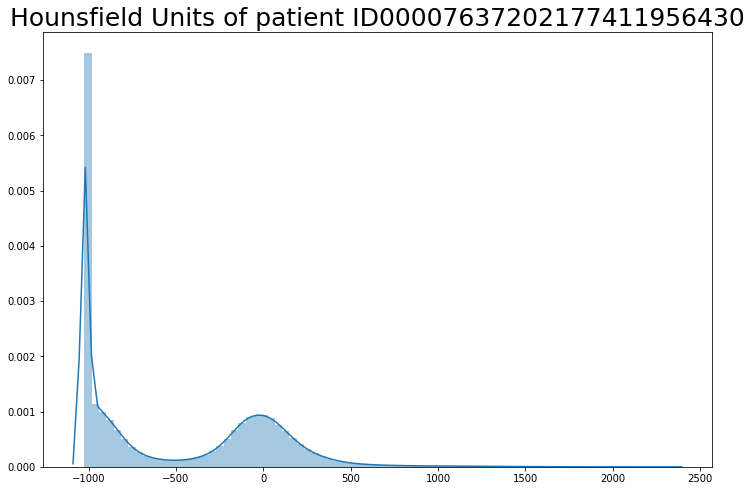

In [59]:
# interactive plot is too heavy
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=test_hu.flatten(), nbinsx=80, histnorm='percent'))
# fig.update_layout(title='Hounsfield Units(HU) of Patient ID00007637202177411956430',
#                   width=800,
#                   height=600)

plt.figure(figsize=(12, 8))
ax = sns.distplot(test_hu.flatten(), bins=80, norm_hist=True)
ax.set_title('Hounsfield Units of patient ID00007637202177411956430', fontsize=25)
plt.show()

In [60]:
def show_dicom_pic(dicom_pixel, p_id=None):
    fig = plt.figure(figsize=(18, len(dicom_pixel)//2))
    for idx, pic in enumerate(dicom_pixel):
        fig.add_subplot(len(dicom_pixel)//5, 5, idx+1)
        plt.imshow(pic, cmap='gray')
        plt.axis('off')
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
        plt.title(str(idx + 1))
        plt.colorbar()
    if p_id:
        fig.suptitle('Patient {}'.format(p_id), fontsize=25)
    fig.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



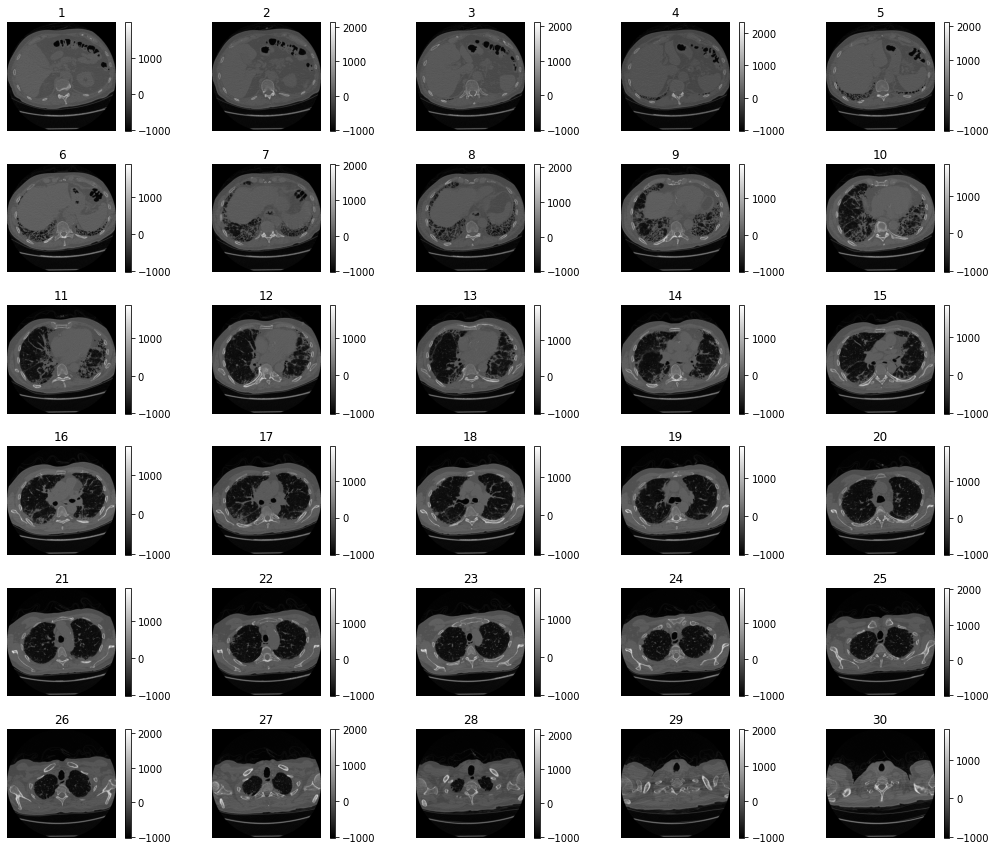

In [61]:
show_dicom_pic(test_hu)

# 3D Visualization

Useful links: 

* https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/
* https://medium.com/@hengloose/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed

Patient ID00102637202206574119190
Slices : 233
Pixels : (512 x 512)


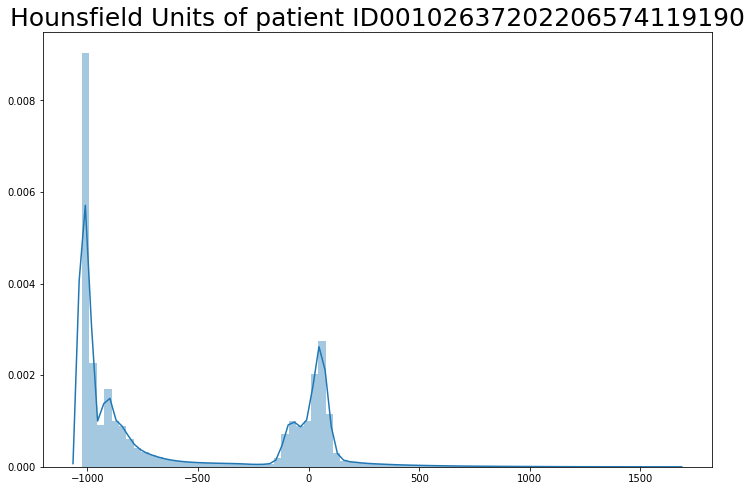

In [62]:
test2 = dicom_file(40)
test2_hu = get_pixels_hu(test2)
print('Patient {}'.format(test2[0].PatientName))
print('Slices : {}\nPixels : ({} x {})'.format(test2_hu.shape[0], test2_hu.shape[1], test2_hu.shape[2]))

plt.figure(figsize=(12, 8))
ax = sns.distplot(test2_hu.flatten(), bins=80, norm_hist=True)
ax.set_title('Hounsfield Units of patient {}'.format(test2[0].PatientName), fontsize=25)
plt.show()

Patient ID00267637202270790561585
Slices : 63
Pixels : (512 x 512)


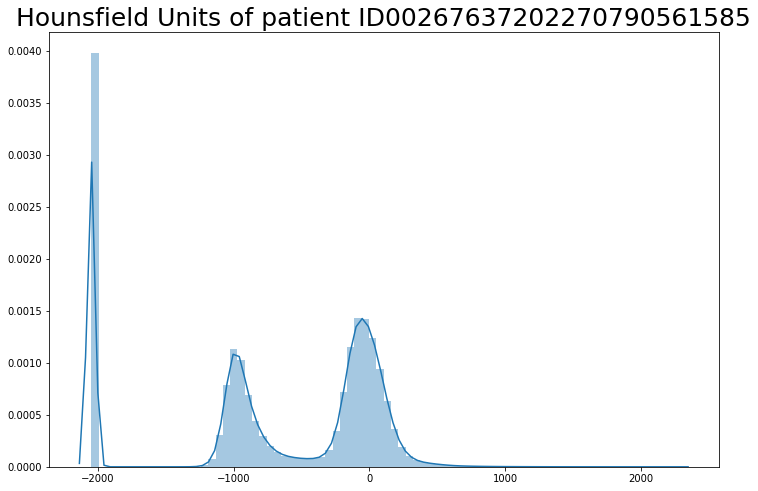

In [63]:
test122 = dicom_file(112)
test122_hu = get_pixels_hu(test122)
print('Patient {}'.format(test122[0].PatientName))
print('Slices : {}\nPixels : ({} x {})'.format(test122_hu.shape[0], test122_hu.shape[1], test122_hu.shape[2]))

plt.figure(figsize=(12, 8))
ax = sns.distplot(test122_hu.flatten(), bins=80, norm_hist=True)
ax.set_title('Hounsfield Units of patient {}'.format(test122[0].PatientName), fontsize=25)
plt.show()

Patient ID00411637202309374271828
Slices : 278
Pixels : (512 x 512)


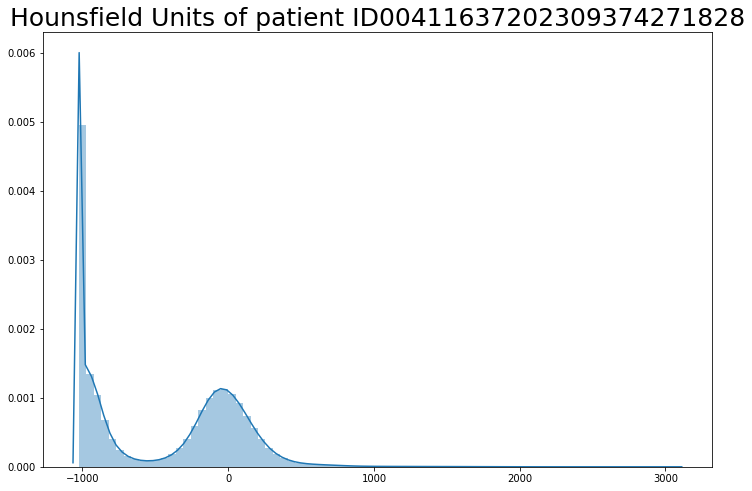

In [64]:
test168 = dicom_file(168)
test168_hu = get_pixels_hu(test168)
print('Patient {}'.format(test168[0].PatientName))
print('Slices : {}\nPixels : ({} x {})'.format(test168_hu.shape[0], test168_hu.shape[1], test168_hu.shape[2]))

plt.figure(figsize=(12, 8))
ax = sns.distplot(test168_hu.flatten(), bins=80, norm_hist=True)
ax.set_title('Hounsfield Units of patient {}'.format(test168[0].PatientName), fontsize=25)
plt.show()

In [65]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]], dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [66]:
def make_mesh(image, threshold):
    p = image.transpose(2, 1, 0)
    
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
    return verts, faces

def static_3d(image, threshold=-300):
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    verts, faces = make_mesh(image, threshold)
    x, y, z = zip(*verts)
    
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    
    ax.add_collection3d(mesh)
    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    plt.show()
    
def interactive_3d(image, threshold=-300):
    verts, faces = make_mesh(image, threshold)
    x, y, z = zip(*verts)
    fig = FF.create_trisurf(x=x,
                            y=y,
                            z=z,
                            plot_edges=False,
                            simplices=faces)
    iplot(fig)

In [67]:
resampled_test2_hu, spacing = resample(test2_hu, test2)

In [68]:
resampled_test122_hu, spacing = resample(test122_hu, test122)

In [69]:
resampled_test168_hu, spacing = resample(test168_hu, test122)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19



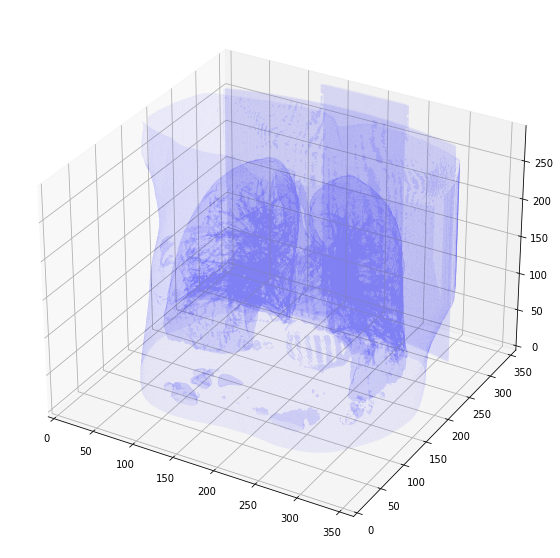

In [70]:
static_3d(resampled_test2_hu)

In [72]:
# static_3d(resampled_test122_hu)

In [ ]:
static_3d(resampled_test168_hu)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19



In [ ]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    return binary_image

In [ ]:
segmented_lungs = segment_lung_mask(resampled_test2_hu, False)
segmented_lungs_fill = segment_lung_mask(resampled_test2_hu, True)

In [ ]:
# segmented_lungs_112 = segment_lung_mask(resampled_test122_hu, False)
# segmented_lungs_112_fill = segment_lung_mask(resampled_test122_hu, True)

In [ ]:
segmented_lungs_168 = segment_lung_mask(resampled_test168_hu, False)
segmented_lungs_168_fill = segment_lung_mask(resampled_test168_hu, True)

## Segmented lungs

In [ ]:
static_3d(segmented_lungs, 1.5)

In [ ]:
# static_3d(segmented_lungs_112, 1.5)

In [ ]:
static_3d(segmented_lungs_168, 1.5)

## Segmented lungs filled

In [ ]:
static_3d(segmented_lungs_fill, 1.5)

In [ ]:
# static_3d(segmented_lungs_112_fill, 1.5)

In [ ]:
static_3d(segmented_lungs_168_fill, 1.5)

## Difference between both

In [ ]:
static_3d(segmented_lungs_fill - segmented_lungs, -0.5)

In [ ]:
# static_3d(segmented_lungs_112_fill - segmented_lungs_112, -0.5)

In [ ]:
static_3d(segmented_lungs_168_fill - segmented_lungs_168, -0.5)

In [ ]:
interactive_3d(segmented_lungs_fill - segmented_lungs, -0.5)

In [ ]:
# interactive_3d(segmented_lungs_112_fill - segmented_lungs_112, -0.5)

In [ ]:
interactive_3d(segmented_lungs_168_fill - segmented_lungs_168, -0.5)

# What's next?
* extract valuable feature from dicom file
